In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors._kde import KernelDensity
from scipy.optimize import minimize



In [2]:
# Varianza de la distribución entera
sigma = 1

# "Observaciones" y "Activos"
NObserv = 10000
NActivos = 1000

# Matriz 10000x1000 
MAleat = np.random.normal(size=(NObserv, NActivos), scale=sigma)

MAleat

array([[ 1.27687654,  0.98265418, -0.81926228, ...,  0.56644537,
        -0.83561447, -1.00338389],
       [ 0.72847651, -2.62601888,  2.24411395, ...,  1.35318395,
         0.40443419, -1.39247014],
       [ 1.42694989,  0.60743448, -1.38559486, ...,  1.47803915,
        -2.18795955,  1.16147035],
       ...,
       [-1.84702607, -0.72453853, -2.1483156 , ...,  1.5581641 ,
         0.40414948, -0.67547678],
       [ 2.32044327,  0.92782659,  1.16958636, ...,  1.90825852,
         0.43365698, -0.60758876],
       [ 0.11573821,  0.19273511,  1.85980786, ..., -0.71292777,
        -0.78212711, -0.15681548]])

In [3]:
# Matriz de covarianzas
MCov = np.cov(MAleat, rowvar=False)
MCov

array([[ 9.83231831e-01,  1.35902831e-02, -5.68178149e-03, ...,
         1.57827452e-02, -9.68760499e-06, -1.53532037e-03],
       [ 1.35902831e-02,  1.02433266e+00, -1.04565095e-02, ...,
        -2.79105945e-03, -1.09056300e-03, -1.31858867e-02],
       [-5.68178149e-03, -1.04565095e-02,  1.01663424e+00, ...,
        -8.13508751e-03,  4.10819615e-03, -6.46776295e-03],
       ...,
       [ 1.57827452e-02, -2.79105945e-03, -8.13508751e-03, ...,
         1.01442661e+00,  7.09995903e-03,  5.99124947e-03],
       [-9.68760499e-06, -1.09056300e-03,  4.10819615e-03, ...,
         7.09995903e-03,  9.96361192e-01,  1.19247246e-02],
       [-1.53532037e-03, -1.31858867e-02, -6.46776295e-03, ...,
         5.99124947e-03,  1.19247246e-02,  1.00406388e+00]])

### <span style="color:white">Distribución de Marcenko-Pastur</span>

In [4]:
# Función de densidad de Marcenko-Pastur
def DensidadMarcencoPastur(sigma, NObs, Nact, pts=1000):
    """
    Función que crea calcula la función de densidad de probabilidad de la distribución de Marcenco-Pastur
    INPUTS:
        · sigma: volatilidad del sistema
        · NObs: número de observaciones (sería el T de la muestra, número de filas)
        · Nact: número de "activos" (sería el N de la muestra, número de columnas)
        · pts: número de puntos para construir la función de densidad
    OUTPUTS:
        · pdf: función de densidad
        · lambda_max: valor máximo de la distribución
        · lambda_min: valor mínimo de la distribución
    """

    aspectRatio = NObs / Nact

    lambdaMenos = sigma**2 * (1 - np.sqrt(1.0 / aspectRatio))**2
    lambdaMas = sigma**2 * (1 + np.sqrt(1.0 / aspectRatio))**2

    lambda_values = np.linspace(lambdaMenos, lambdaMas, pts)

    pdf = aspectRatio / (2 * np.pi * sigma * lambda_values) * np.sqrt(((lambdaMas - lambda_values) * (lambda_values - lambdaMenos)))
    pdf = pd.Series(pdf, index=lambda_values)

    return pdf, lambdaMas, lambdaMenos

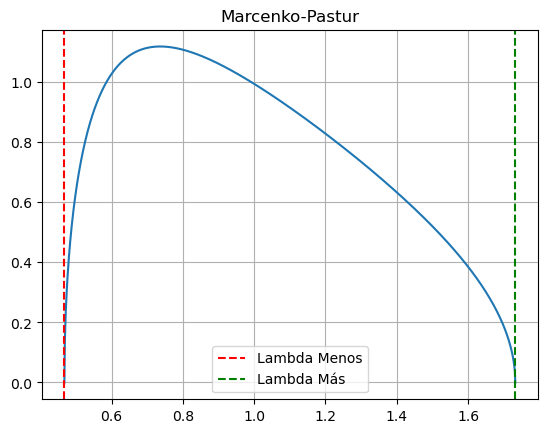

In [5]:
sigma = 1
NObserv = 10000
NActivos = 1000

pdf, lambdaMas, lambdaMenos = DensidadMarcencoPastur(sigma, NObserv, NActivos, 1000)

plt.plot(pdf.index, pdf.values)
plt.title("Marcenko-Pastur")
plt.axvline(x=lambdaMenos, color="r", linestyle="--", label="Lambda Menos")
plt.axvline(x=lambdaMas, color="g", linestyle="--", label="Lambda Más")
plt.legend()
plt.grid(True)
plt.show()

### <span style="color:white">Comparando con distribución empírica de matriz aleatoria</span>

In [6]:
x = np.random.normal(size=(NObserv, NActivos), scale=sigma)
cov = np.cov(x, rowvar=False)
cov

array([[ 1.01843421,  0.00533856,  0.01198692, ...,  0.00145885,
         0.01302751, -0.01132664],
       [ 0.00533856,  0.99211265, -0.00449182, ..., -0.00872701,
        -0.0200236 , -0.01610182],
       [ 0.01198692, -0.00449182,  0.99299865, ...,  0.00231671,
        -0.00781609,  0.01292294],
       ...,
       [ 0.00145885, -0.00872701,  0.00231671, ...,  0.98381311,
        -0.00728593,  0.01426271],
       [ 0.01302751, -0.0200236 , -0.00781609, ..., -0.00728593,
         1.00465228,  0.01476981],
       [-0.01132664, -0.01610182,  0.01292294, ...,  0.01426271,
         0.01476981,  1.00460445]])

In [7]:
eVal, eVec = np.linalg.eigh(cov)
indices = eVal.argsort()[::-1]
eVal, eVec = eVal[indices], eVec[:, indices]

In [8]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(eVal.reshape(-1, 1))
x = np.unique(eVal).reshape(-1, 1)
logProb = kde.score_samples(x)
kde_pdf = pd.Series(np.exp(logProb), index=x.flatten())

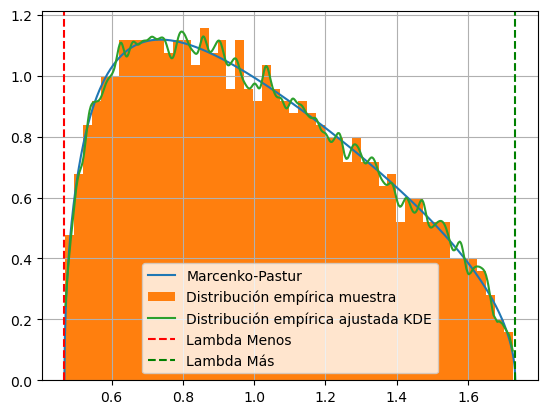

In [9]:
plt.plot(pdf.index, pdf.values, label="Marcenko-Pastur")
plt.hist(eVal, density=True, bins=50, label="Distribución empírica muestra")
plt.plot(kde_pdf.index, kde_pdf.values, label="Distribución empírica ajustada KDE")
plt.axvline(x=lambdaMenos, color="r", linestyle="--", label="Lambda Menos")
plt.axvline(x=lambdaMas, color="g", linestyle="--", label="Lambda Más")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Función para crear una matriz de covarianzas con ruido

def matrizCovAletoria(num_columnas, num_observaciones):
    x = np.random.normal(size=(num_observaciones, num_columnas))
    cov = np.dot(x.T,x)
    cov = cov + np.diag(np.random.uniform(size=num_columnas))
    return cov

In [11]:
alpha = 0.99
q = int(NObserv/NActivos)
num_columnas = NActivos
num_observaciones = 100

covAux = np.cov(np.random.normal(size=(num_columnas*q, num_columnas)), rowvar=0)

CovMod = alpha * covAux + (1 - alpha) * matrizCovAletoria(num_columnas, num_observaciones)
CovMod

array([[ 2.07833548, -0.00598635, -0.18022172, ...,  0.05674796,
        -0.05265516,  0.12486245],
       [-0.00598635,  1.86157431, -0.05814931, ...,  0.10942542,
         0.1834534 ,  0.07144487],
       [-0.18022172, -0.05814931,  1.88157176, ..., -0.05940739,
        -0.06264667, -0.04364988],
       ...,
       [ 0.05674796,  0.10942542, -0.05940739, ...,  2.15079004,
        -0.03841965,  0.10164124],
       [-0.05265516,  0.1834534 , -0.06264667, ..., -0.03841965,
         2.22309816, -0.05191915],
       [ 0.12486245,  0.07144487, -0.04364988, ...,  0.10164124,
        -0.05191915,  1.95628127]])

In [12]:

eValMod, eVecMod = np.linalg.eigh(CovMod)
indices = eValMod.argsort()[::-1]
eValMod, eVecMod = eValMod[indices], eVecMod[:, indices]

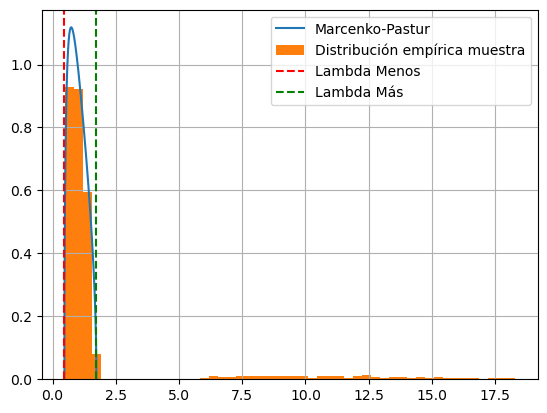

In [13]:
plt.plot(pdf.index, pdf.values, label="Marcenko-Pastur")
plt.hist(eValMod, density=True, bins=50, label="Distribución empírica muestra")
plt.axvline(x=lambdaMenos, color="r", linestyle="--", label="Lambda Menos")
plt.axvline(x=lambdaMas, color="g", linestyle="--", label="Lambda Más")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#Función que ejecuta el denoise (quita el ruido)
def denoise(eVal, eVec, NObserv, NActivos, sigma):
    
    _, lambdaMas, lambdaMenos = DensidadMarcencoPastur(sigma, NObserv, NActivos)
    eValDen = eVal.copy()
    eVal_ruido = eValDen[eValDen<=lambdaMas]
    eVal_ruido_medio = eVal_ruido.mean()
    eValDen[eValDen<=lambdaMas] = eVal_ruido_medio

    denoisedMatrix = np.dot(eVec, np.diag(eValDen)).dot(eVec.T)

    return denoisedMatrix

In [15]:
denoisedCov = denoise(eValMod, eVecMod, NObserv, NActivos, sigma)
denoisedCov

array([[ 2.08302538, -0.01575073, -0.16579829, ...,  0.04854398,
        -0.04850492,  0.13177375],
       [-0.01575073,  1.84703183, -0.05431789, ...,  0.10272325,
         0.16889375,  0.06247898],
       [-0.16579829, -0.05431789,  1.89031197, ..., -0.06365853,
        -0.06161222, -0.03915618],
       ...,
       [ 0.04854398,  0.10272325, -0.06365853, ...,  2.14399745,
        -0.02224016,  0.1026798 ],
       [-0.04850492,  0.16889375, -0.06161222, ..., -0.02224016,
         2.21623648, -0.04435719],
       [ 0.13177375,  0.06247898, -0.03915618, ...,  0.1026798 ,
        -0.04435719,  1.96263438]])

In [ ]:
# Cálculo del Denoised
eValDen, eVecDen = np.linalg.eigh(denoisedCov)
indices = eValDen.argsort()[::-1]
eValDen, eVecDen = eValDen[indices], eVecDen[:, indices]

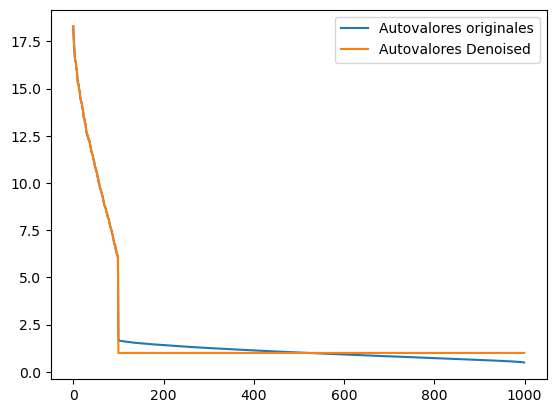

In [17]:
plt.plot(eValMod, label="Autovalores originales")
plt.plot(eValDen, label="Autovalores Denoised")
plt.legend()
plt.show()

In [18]:
# Función que ejecuta el shrinkage
def shrinkage(eVal, eVec, NObserv, NActivos, sigma, alpha):
    
    _, lambdaMas, lambdaMenos = DensidadMarcencoPastur(sigma, NObserv, NActivos)
    eValSh = eVal.copy()
    eVecSh = eVec.copy()
    eVal_ruido = eValSh[eValSh<=lambdaMas]
    eVec_ruido = eVecSh[:,eValSh<=lambdaMas]

    eVal_signal = eValSh[eValSh>lambdaMas]
    eVec_signal = eVecSh[:,eValSh>lambdaMas]

    shrinkedMatrix = np.dot(eVec_signal, np.diag(eVal_signal)).dot(eVec_signal.T) + alpha * \
                        np.dot(eVec_ruido, np.diag(eVal_ruido)).dot(eVec_ruido.T) + \
                        (1-alpha)*np.diag(np.dot(eVec_signal, np.diag(eVal_signal)).dot(eVec_signal.T) ) 

    return shrinkedMatrix

In [19]:

alpha = 0.3 # Si va a cero -> shrikage total
shrinkedCov = shrinkage(eValMod, eVecMod, NObserv, NActivos, sigma, alpha)
shrinkedCov

array([[2.30764824, 0.6385166 , 0.50613412, ..., 0.9354899 , 0.88957016,
        0.88652026],
       [0.82816975, 1.86331358, 0.62826082, ..., 0.99475709, 1.12210555,
        0.81797017],
       [0.66115445, 0.59362799, 1.93857846, ..., 0.81754792, 0.87399073,
        0.70514296],
       ...,
       [0.89605526, 0.76566929, 0.62309295, ..., 2.40825389, 0.91596993,
        0.85605289],
       [0.79104747, 0.8339297 , 0.6204477 , ..., 0.85688187, 2.54812244,
        0.70046684],
       [0.98126305, 0.7230598 , 0.64486541, ..., 0.99023032, 0.89373232,
        2.0815464 ]])

In [20]:
eValSh, eVecSh = np.linalg.eigh(shrinkedCov)
indices = eValSh.argsort()[::-1]
eValSh, eVecSh = eValSh[indices], eVecSh[:, indices]

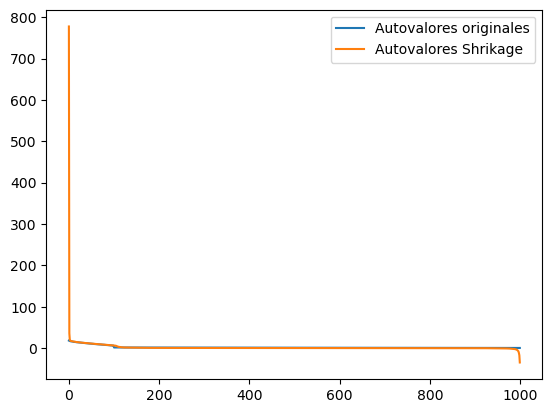

In [21]:
plt.plot(eValMod, label="Autovalores originales")
plt.plot(eValSh, label="Autovalores Shrikage")
plt.legend()
plt.show()

In [22]:
def error(sigma, eVal, NObserv, NActivos):
    """
    Función que calcula el error entre la función de densidad teórica por Marcenko-Pastur
    y la empírica
    """
    
    densMP,_ , _ = DensidadMarcencoPastur(float(sigma), NObserv, NActivos) 

    
    kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(eVal.reshape(-1, 1))
    x = np.unique(eVal).reshape(-1, 1)
    logProb = kde.score_samples(x)
    densEmp = pd.Series(np.exp(logProb), index=x.flatten())

    sse = np.sum((densEmp - densMP) ** 2)
    return sse

In [23]:
NObserv = 1000
NActivos = 500


MAleat = np.random.normal(size=(NObserv, NActivos))
cov = np.cov(MAleat)

eVal, _ = np.linalg.eigh(cov)
indices = eVal.argsort()[::-1]
eVal= eVal[indices]


sigma = minimize(lambda *x: error(*x), x0=1, args=(eVal, NObserv, NActivos),
                   bounds=((1E-5, 1 - 1E-5),))
sigma.x[0]

/var/folders/lr/vt7z07r96xs_kf3mfyld482m0000gn/T/ipykernel_20163/2554061419.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  densMP,_ , _ = DensidadMarcencoPastur(float(sigma), NObserv, NActivos)
/var/folders/lr/vt7z07r96xs_kf3mfyld482m0000gn/T/ipykernel_20163/2554061419.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  densMP,_ , _ = DensidadMarcencoPastur(float(sigma), NObserv, NActivos)


0.99999